# Business Understanding

## Project Domain

Analisis dan Prediksi Data Iklim
Proyek ini berada dalam domain analisis Data Science dan Machine Learning , khususnya data iklim dan cuaca berdasarkan data historis. Data digunakan untuk mengetahui tren suhu, kelembaban, dan parameter lainnya, serta membangun model prediktif untuk meramalkan kondisi cuaca di masa depan.:)

## Problem Statements

Data historis iklim kota Jena antara tahun 2009 hingga 2016 menunjukkan berbagai suhu dan kelembaban yang kompleks. Namun, tanpa alat bantu analisis atau sistem prediksi, sulit bagi masyarakat atau lembaga untuk memahami pola iklim tersebut dan mengantisipasi perubahan ekstrem yang mungkin terjadi. Kurangnya sistem prediksi berbasis data membuat pengambilan keputusan menjadi kurang akurat, terutama dalam konteks pertanian, energi, atau perencanaan kota.

## Goals

Menganalisis dataset iklim dari Jena untuk mengidentifikasi pola dan tren cuaca dari tahun 2009 hingga 2016.

Menyebutkan model pembelajaran mesin untuk memprediksi suhu udara berdasarkan parameter cuaca lainnya seperti kelembaban, tekanan udara, kecepatan angin, dan sinar matahari.

Menyajikan visualisasi data dan hasil prediksi dalam bentuk dashboard sederhana atau grafik interaktif agar mudah dipahami pengguna non-teknis.

## Solution Statements

Proyek ini akan mengembangkan solusi berupa aplikasi atau sistem analisis dan prediksi iklim berbasis data historis menggunakan pembelajaran mesin algoritma (seperti regresi atau LSTM). Sistem ini akan membaca data iklim dari file CSV, membersihkannya, mengekstrak fitur penting, lalu melatih model prediktif. Hasil prediksi dan analisis akan divisualisasikan secara informatif, membantu pengguna memahami tren iklim dan membuat keputusan yang lebih baik berdasarkan data.



# Data Understanding

## Import data dari kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mriosofiellapoetra33","key":"331235d5a898c3f5d43b1a338c83e3a0"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [6]:
!kaggle datasets download -d stytch16/jena-climate-2009-2016

Dataset URL: https://www.kaggle.com/datasets/stytch16/jena-climate-2009-2016
License(s): CC0-1.0


In [7]:
!unzip -o -q jena-climate-2009-2016.zip -d jena_climate_2009_2016-dataset


In [8]:
!ls jena_climate_2009_2016-dataset

jena_climate_2009_2016.csv


## Import Library yang dibutuhkan

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [10]:
import pandas as pd

csv_path = "jena_climate_2009_2016-dataset/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
if df.columns[0] != "Date Time":
    df.rename(columns={df.columns[0]: "Date Time"}, inplace=True)
df["Date Time"] = pd.to_datetime(df["Date Time"], dayfirst=True)

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date Time        420551 non-null  datetime64[ns]
 1   p (mbar)         420551 non-null  float64       
 2   T (degC)         420551 non-null  float64       
 3   Tpot (K)         420551 non-null  float64       
 4   Tdew (degC)      420551 non-null  float64       
 5   rh (%)           420551 non-null  float64       
 6   VPmax (mbar)     420551 non-null  float64       
 7   VPact (mbar)     420551 non-null  float64       
 8   VPdef (mbar)     420551 non-null  float64       
 9   sh (g/kg)        420551 non-null  float64       
 10  H2OC (mmol/mol)  420551 non-null  float64       
 11  rho (g/m**3)     420551 non-null  float64       
 12  wv (m/s)         420551 non-null  float64       
 13  max. wv (m/s)    420551 non-null  float64       
 14  wd (deg)         420

## Exploratory Data Analysis

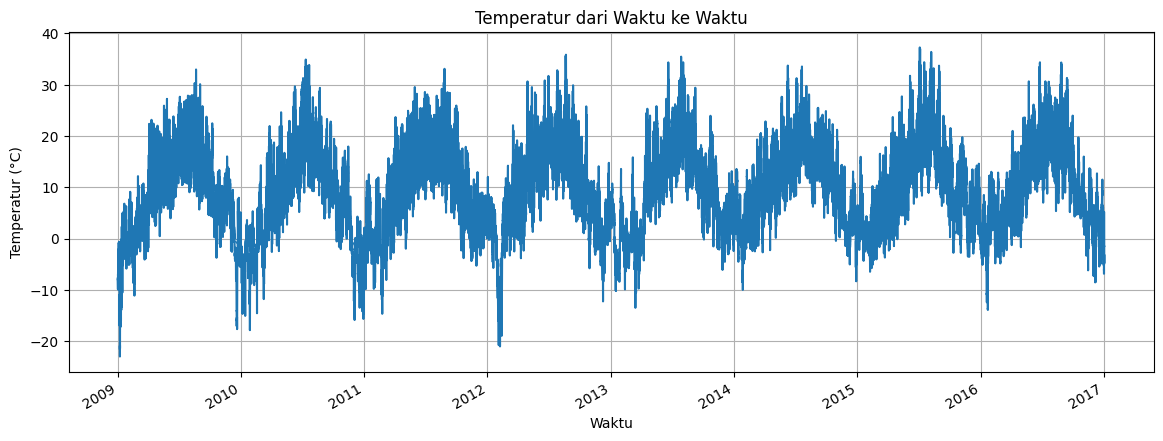

In [11]:
plt.figure(figsize=(14, 5))
df.set_index("Date Time")["T (degC)"].plot()
plt.title("Temperatur dari Waktu ke Waktu")
plt.xlabel("Waktu")
plt.ylabel("Temperatur (°C)")
plt.grid(True)
plt.show()

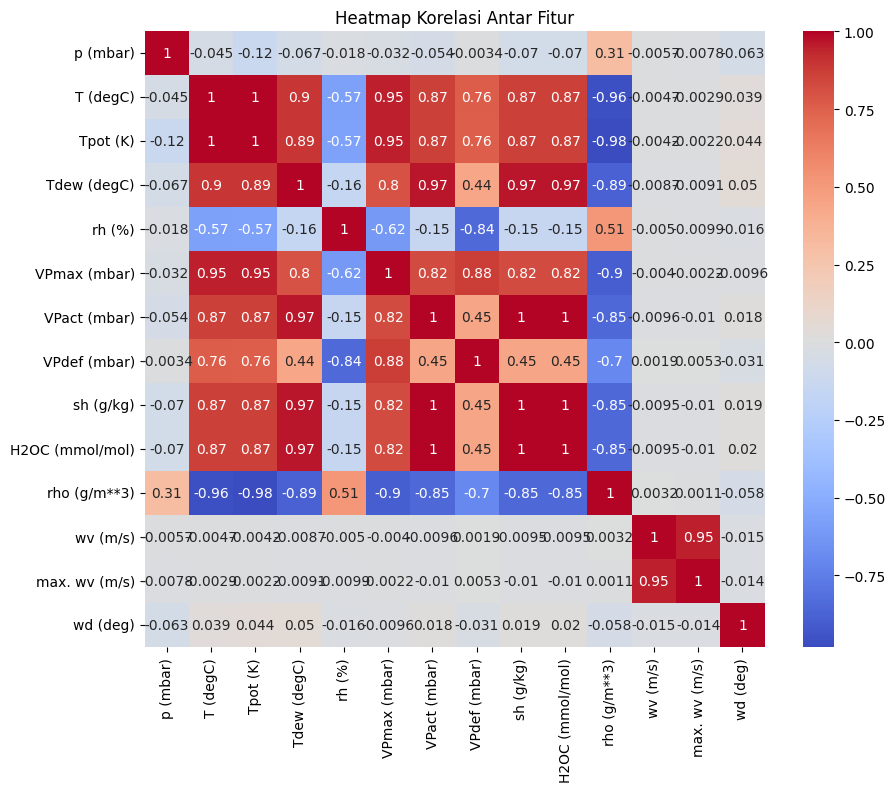

In [12]:
plt.figure(figsize=(10, 8))
num_df = df.drop(columns=["Date Time"])
sns.heatmap(num_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

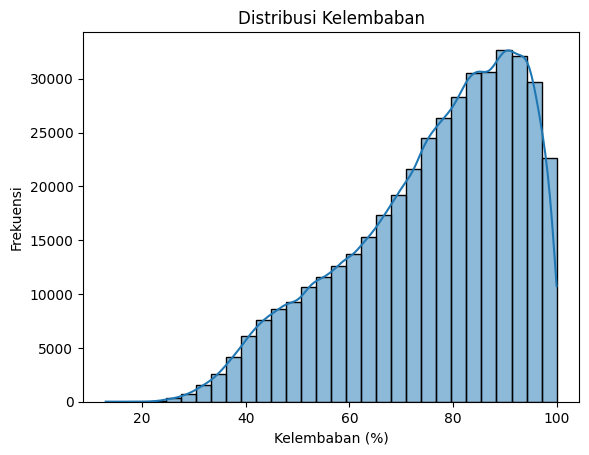

In [13]:
sns.histplot(df['rh (%)'], bins=30, kde=True)
plt.title("Distribusi Kelembaban")
plt.xlabel("Kelembaban (%)")
plt.ylabel("Frekuensi")
plt.show()

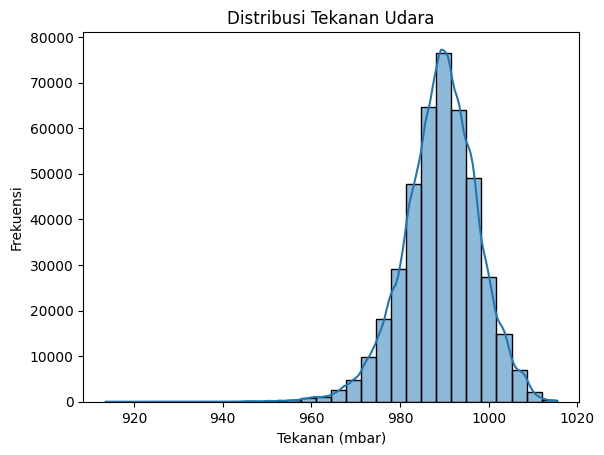

In [14]:
sns.histplot(df['p (mbar)'], bins=30, kde=True)
plt.title("Distribusi Tekanan Udara")
plt.xlabel("Tekanan (mbar)")
plt.ylabel("Frekuensi")
plt.show()

<ipython-input-15-634ae771076d>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_wind = df.set_index("Date Time")["wv (m/s)"].resample('M').mean()


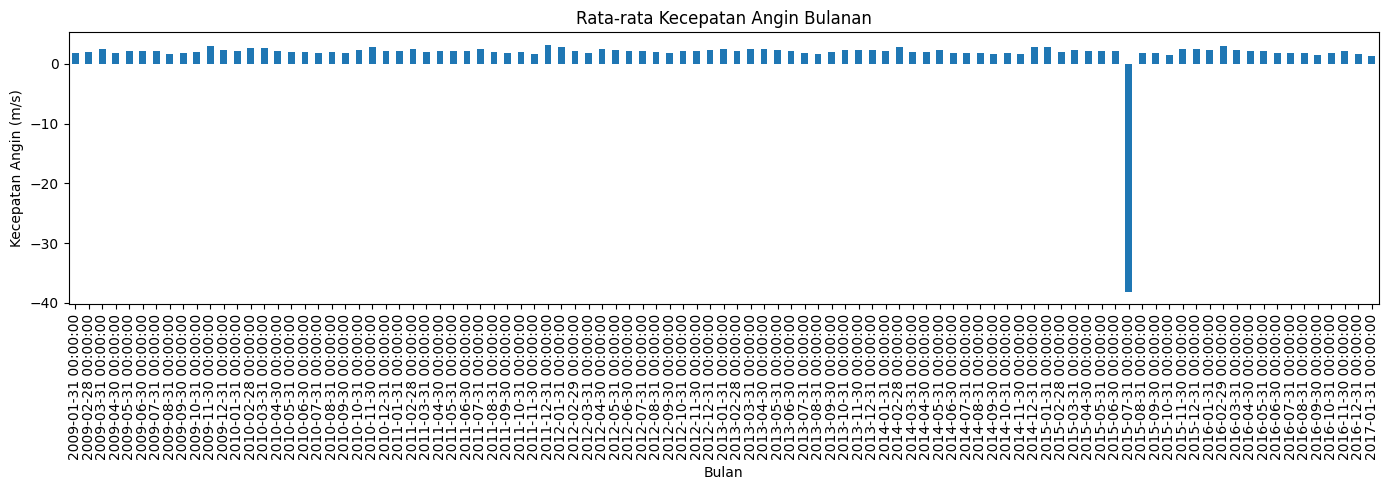

In [15]:
monthly_avg_wind = df.set_index("Date Time")["wv (m/s)"].resample('M').mean()
monthly_avg_wind.plot(kind='bar', figsize=(14,5))
plt.title("Rata-rata Kecepatan Angin Bulanan")
plt.ylabel("Kecepatan Angin (m/s)")
plt.xlabel("Bulan")
plt.tight_layout()
plt.show()

# Data Preparation

In [16]:
selected_df = df[['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)']].copy()


In [17]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(selected_df)

In [18]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_x = data[i:i+window_size]
        seq_y = data[i+window_size][0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [19]:

window_size = 72
X, y = create_sequences(data_scaled, window_size)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [20]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modeling

In [24]:
print(f"Shape X_train: {X_train.shape}")

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(X_train, y_train, validation_split=0.2, epochs=1, batch_size=64, verbose=1, callbacks=callbacks)

Shape X_train: (336383, 72, 4)
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 987s 234ms/step - loss: 0.0048 - mae: 0.0418 - val_loss: 9.9392e-05 - val_mae: 0.0075 - learning_rate: 0.0010


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 72, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,709 (1.35 MB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,140 (918.52 KB)

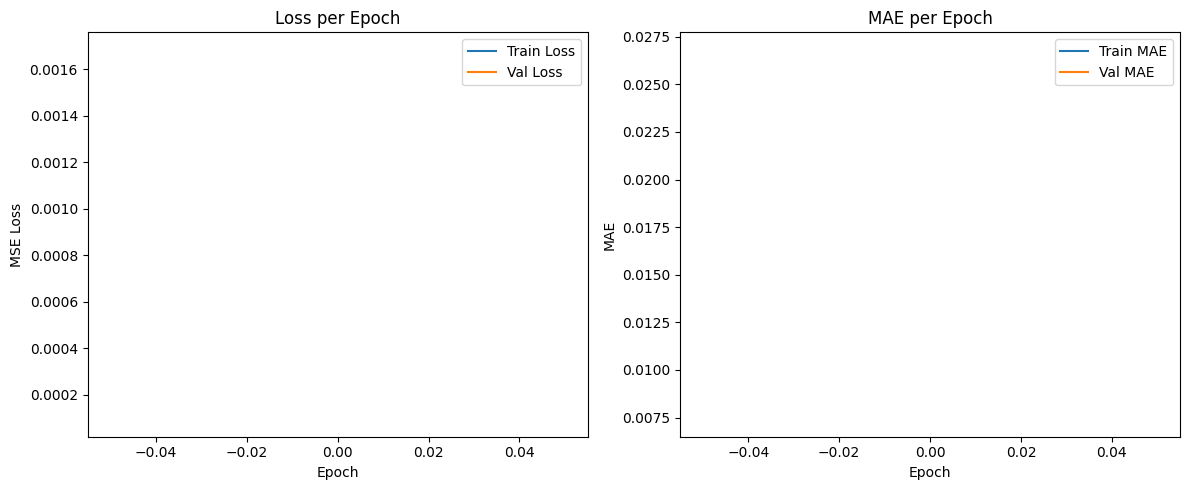

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation

In [27]:
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

2628/2628 ━━━━━━━━━━━━━━━━━━━━ 131s 50ms/step
R² Score: 0.99
MAE: 0.0077
RMSE: 0.0116


# Deployment

## Model Simulation

In [28]:

features = ['p (mbar)', 'Tpot (K)', 'rh (%)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
target = 'T (degC)'

data = df[features + [target]].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

X_all = scaled[:, :-1]
y_all = scaled[:, -1]

def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 10
X_seq, y_seq = create_sequences(X_all, y_all, window_size)


X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Bangun model RNN LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)


loss = model.evaluate(X_test, y_test)
print("Test MSE:", loss)


y_pred = model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 0.0017 - val_loss: 2.8092e-05
Epoch 2/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: 3.3826e-05 - val_loss: 1.4644e-05
Epoch 3/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 2.1232e-05 - val_loss: 1.2210e-05
Epoch 4/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step - loss: 1.6166e-05 - val_loss: 1.1728e-05
Epoch 5/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - loss: 1.5167e-05 - val_loss: 2.9748e-05
Epoch 6/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 1.4731e-05 - val_loss: 1.6401e-05
Epoch 7/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 1.4321e-05 - val_loss: 1.0282e-05
Epoch 8/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 1.3837e-05 - val_loss: 1.2090e-05
Epoch 9/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - loss: 1.3876e-05 - val_loss: 1.1391e-05
Epoch 10/10
4732/4732 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 1.3568e-05 - val_loss: 1.0867e-05
2629/2629 ━━━━━━━━━━━━━━━━━━━

SAVE MODEL


In [30]:
from google.colab import files

# Unduh file TFLite model
files.download("model.tflite")

# Unduh scaler
files.download("scaler.pkl")

# Unduh label encoder
files.download("label_encoder.pkl")

# Unduh requirements.txt
files.download("requirements.txt")


FileNotFoundError: Cannot find file: model.tflite